In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

from tools import add_labels, add_largedot_legend, log_transform, pearson_residuals, prepare_largest_batch, sqrt_lazy, normalize_and_scale

#### Some aesthetics

In [2]:
title_fontsize = 20
title_fontweight = "bold"
cmap = sns.cubehelix_palette(6, start=0.9, rot=0, dark=0.9, light=0.2, reverse=True,as_cmap=True)
xmean_label = 'expression mean'

# Scanpy colors (originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)
cmap_colors = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

excluded_color_ids = [0,7,17,31,41,45,50,88,96,105] #excluded for low contrast on white
cmap_colors = [c for i,c in enumerate(cmap_colors) if not i in excluded_color_ids]

#### Load datasets

In [3]:
files =['datasets/retina/macosko_all/GSE63472_P14Retina_merged_digital_expression.txt_preprocessed.pickle',
        'datasets/retina/shekhar_bipolar/GSE81904_BipolarUMICounts_Cell2016.txt.gz_preprocessed.pickle',
        'datasets/retina/tran_ganglion/GSE133382_AtlasRGCs_CountMatrix.csv_preprocessed.pickle']

labels = ['macosko',
          'shekhar_bipolar',
          'tran_ganglion']

datasets=[]
for file,label in zip(files,labels):
    with open(file, "rb") as f:
        dataset = pickle.load(f)
        dataset['labelshort'] = label
    
    
    if label in ['macosko','shekhar_bipolar']:
        prepare_largest_batch(dataset,extra_keys=['replicates'])
    else:
        prepare_largest_batch(dataset)
    
    n_clusters = len(np.unique(dataset['clusters']))
    dataset['cmap']=ListedColormap(cmap_colors[:n_clusters])
    dataset['gene_means'] = np.array(np.mean(dataset['counts'],axis=0)).flatten()
    dataset['depths'] = np.array(np.sum(dataset['counts'],axis=1)).flatten()
    
    datasets.append(dataset)

Of 19252 total genes, returning 17973 genes that are detected in 5 or more cells.
Output shape: (24769, 17973)
Of 18149 total genes, returning 16520 genes that are detected in 5 or more cells.
Output shape: (13987, 16520)
Of 18137 total genes, returning 17685 genes that are detected in 5 or more cells.
Output shape: (15750, 17685)


# Compute normalization

#### Analytical Pearson residuals

In [4]:
%%time
for dataset in datasets:
    dataset['residuals_theta100'] = pearson_residuals(dataset['counts'].toarray(),100)

CPU times: user 24.7 s, sys: 4.18 s, total: 28.9 s
Wall time: 28.9 s


#### Sqrt transform

In [5]:
%%time
for dataset in datasets:
    dataset['sqrt_lazy'] = sqrt_lazy(dataset['counts'].toarray())

CPU times: user 7.98 s, sys: 848 ms, total: 8.82 s
Wall time: 8.82 s


#### Log transform and bare normalization

In [6]:
%%time
for dataset in datasets:
    dataset['normalized'] = normalize_and_scale(dataset['counts'].toarray(),scale=1)
    dataset['log1p_medianscale'] = log_transform(dataset['counts'].toarray(),scale_mode='median')
    dataset['log1p_10kscale'] = log_transform(dataset['counts'].toarray(),scale=10000,scale_mode='user_provided_scale')

CPU times: user 30 s, sys: 6.07 s, total: 36.1 s
Wall time: 36.1 s


#### Load tSNEs

In [7]:
for dataset in datasets:
    
    with open('tsne/tsne_%s_sqrt_lazy_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['sqrt_lazy_tsne'] = pickle.load(f)  
    with open('tsne/tsne_%s_residuals_theta100_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['residuals_theta100_tsne'] = pickle.load(f)    
    with open('tsne/tsne_%s_glmpca-py_nb_thetaFixed100_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['glmpca-py_nb_thetaFixed100_tsne'] = pickle.load(f)
        
    with open('tsne/tsne_%snormalized_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['normalized_tsne'] = pickle.load(f)
    with open('tsne/tsne_%slog1p_medianscale_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['log1p_medianscale_tsne'] = pickle.load(f)
    with open('tsne/tsne_%slog1p_10kscale_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['log1p_10kscale_tsne'] = pickle.load(f)

In [8]:
label_mapping_paper = {'shekhar_bipolar_largestBatch':'Bipolar cells\n(Shekhar et al. 2016)',
                        'tran_ganglion_largestBatch':'Ganglion cells\n(Tran et al. 2019)',
                        'macosko_largestBatch':'All retinal cell classes\n(Macosko et al. 2015)'}

# Gene selection

In [9]:
def find_variable_genes(dataset,n_genes=100):
    
    ##compute variance per method
    dataset['sqrt_lazy_var'] = np.var(dataset['sqrt_lazy'],axis=0)
    dataset['residuals_theta100_var'] = np.var(dataset['residuals_theta100'],axis=0)

    dataset['normalized_var'] = np.var(dataset['normalized'],axis=0)
    dataset['log1p_medianscale_var'] = np.var(dataset['log1p_medianscale'],axis=0)
    dataset['log1p_10kscale_var'] = np.var(dataset['log1p_10kscale'],axis=0)
    
    
    ##get top100 variable genes per method
    dataset['sqrt_lazy_threshold'] = np.sort(dataset['sqrt_lazy_var'])[-n_genes]
    dataset['residuals_theta100_threshold'] = np.sort(dataset['residuals_theta100_var'])[-n_genes]
    
    dataset['normalized_threshold'] = np.sort(dataset['normalized_var'])[-n_genes]
    dataset['log1p_medianscale_threshold'] = np.sort(dataset['log1p_medianscale_var'])[-n_genes]
    dataset['log1p_10kscale_threshold'] = np.sort(dataset['log1p_10kscale_var'])[-n_genes]

    dataset['residuals_theta100_vargenes_idx'] = dataset['residuals_theta100_var'] > dataset['residuals_theta100_threshold']
    dataset['sqrt_lazy_vargenes_idx'] = dataset['sqrt_lazy_var'] > dataset['sqrt_lazy_threshold']
    
    dataset['normalized_vargenes_idx'] = dataset['normalized_var'] > dataset['normalized_threshold']
    dataset['log1p_medianscale_vargenes_idx'] = dataset['log1p_medianscale_var'] > dataset['log1p_medianscale_threshold']
    dataset['log1p_10kscale_vargenes_idx'] = dataset['log1p_10kscale_var'] > dataset['log1p_10kscale_threshold']

In [10]:
%%time
[find_variable_genes(d) for d in datasets]

CPU times: user 18.3 s, sys: 904 ms, total: 19.2 s
Wall time: 19.2 s


[None, None, None]

## Figure S3

In [11]:
dotsize = 2
starsize = 125
staredges = 0.85
legend_loc = (0.1,0.6)
titleletter_loc = (-0.17,1.015)
hline_width = 1.5
xmin = min(dataset['gene_means'])
xmax = max(dataset['gene_means'])*1.5

In [12]:
dataset = datasets[0]

example_genes =             ['Opn1mw',                                  'Gng13',                                      'Mgarp',                               'Glul']
example_genes_idx = np.isin(dataset['genes'],example_genes)
example_gene_textoffsets_a = [np.array([0,-0.095]),                     np.array([0.1,-0.3]),                         np.array([0.5,-0.35]),                  np.array([-0.1,0.2])]
example_gene_lines_a =       [[np.array([0,0.002]),np.array([0,-0.02])],  [np.array([-0.1,0.03]),np.array([0,-0.1])],       [],                                     []]

example_gene_textoffsets_b = [np.array([0,-4.45]),                        np.array([0.1,-5]),                            np.array([0.65,-0.25]),                    np.array([0,3])]

example_gene_lines_b =       [[np.array([0,0.1]),np.array([0,-1])],      [np.array([-0.1,0.25]),np.array([0,-1])],        [],                                     []]

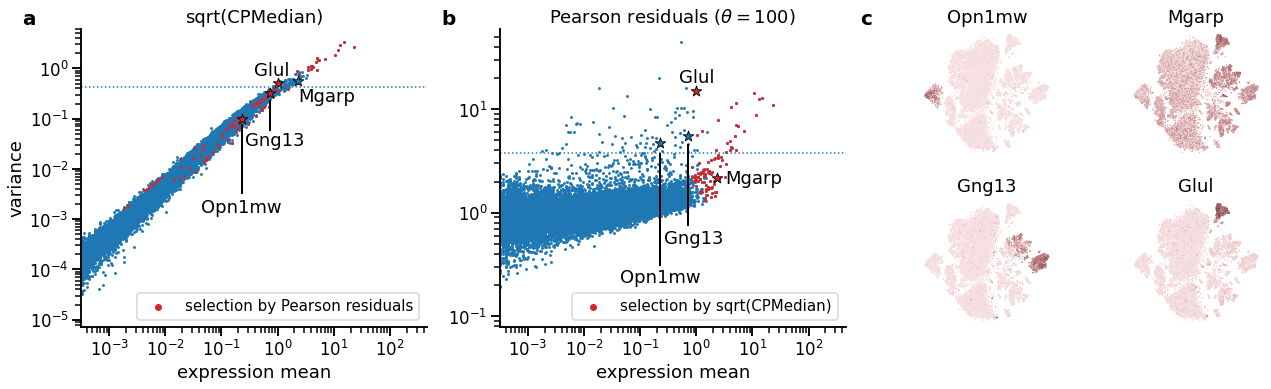

In [13]:
gene_means = dataset['gene_means']
sqrt_var =  dataset['sqrt_lazy_var']
sqrt_variable_genes_idx = dataset['sqrt_lazy_vargenes_idx']
residual_var = dataset['residuals_theta100_var']
residuals_variable_genes_idx = dataset['residuals_theta100_vargenes_idx']

with sns.plotting_context("talk"):


    fig = plt.figure(figsize=(18,6))
    gs = GridSpec(2, 6, figure=fig) 

    ax1 = fig.add_subplot(gs[:, 0:2])
    ax2 = fig.add_subplot(gs[:, 2:4])    
    supaxis = fig.add_subplot(gs[:, 4:6])      
    ax3 = fig.add_subplot(gs[0, 4])  
    ax4 = fig.add_subplot(gs[1, 4])  
    ax5 = fig.add_subplot(gs[0, 5])  
    ax6 = fig.add_subplot(gs[1, 5])  

    tsne_axes = [ax3,ax4,ax5,ax6]

    ax1.text(*titleletter_loc,'a',transform=ax1.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax1.set_title('sqrt(CPMedian)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim((xmin,xmax))
    ax1.set_xlabel(xmean_label)
    ax1.set_ylabel('variance')
    ax1.scatter(gene_means,sqrt_var,s=dotsize, rasterized=True)
    ax1.scatter(gene_means[residuals_variable_genes_idx],sqrt_var[residuals_variable_genes_idx],color='tab:red',s=dotsize,label='selection by Pearson residuals', rasterized=True)
    ax1.scatter(gene_means[residuals_variable_genes_idx & example_genes_idx],sqrt_var[residuals_variable_genes_idx & example_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges, rasterized=True)
    ax1.scatter(gene_means[~residuals_variable_genes_idx & example_genes_idx],sqrt_var[~residuals_variable_genes_idx & example_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges, rasterized=True)
    ax1.hlines(dataset['sqrt_lazy_threshold'],xmin,xmax,linestyle=':',linewidth=hline_width)    

    add_labels(dataset,xdata=gene_means, ydata=sqrt_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_a,lines=example_gene_lines_a,ax=ax1)
    add_largedot_legend(ax1,'lower right',dict(fontsize=15))


    ax2.text(*titleletter_loc,'b',transform=ax2.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax2.set_title(r'Pearson residuals ($\theta=100$)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim((xmin,xmax))
    ax2.set_xlabel(xmean_label)    
    ax2.scatter(gene_means,residual_var,s=dotsize, rasterized=True)
    ax2.scatter(gene_means[sqrt_variable_genes_idx],residual_var[sqrt_variable_genes_idx],color='tab:red',s=dotsize,label='selection by sqrt(CPMedian)', rasterized=True)    
    ax2.scatter(gene_means[example_genes_idx & sqrt_variable_genes_idx],residual_var[example_genes_idx & sqrt_variable_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges, rasterized=True)
    ax2.scatter(gene_means[example_genes_idx & ~sqrt_variable_genes_idx],residual_var[example_genes_idx & ~sqrt_variable_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges, rasterized=True)
    ax2.hlines(dataset['residuals_theta100_threshold'],xmin,xmax,linestyle=':',linewidth=hline_width)    

    add_labels(dataset,xdata=gene_means, ydata=residual_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_b,lines=example_gene_lines_b,ax=ax2)
    add_largedot_legend(ax2,'lower right',dict(fontsize=15))    
    

    supaxis.text(*titleletter_loc,'c',transform=supaxis.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)    
    supaxis.axis('off')
    for (tsne_ax,example_gene) in zip(tsne_axes,example_genes):        

        gene_idx = dataset['genes'] == example_gene
        sqrted_counts = np.squeeze(dataset['sqrt_lazy'][:,gene_idx])

        tsne_ax.set_title(example_gene.lower().capitalize())
        tsne_ax.scatter(dataset['residuals_theta100_tsne']['coords'][:,0], dataset['residuals_theta100_tsne']['coords'][:,1], s=1,c=sqrted_counts, edgecolor='none',cmap=cmap, rasterized=True)
        tsne_ax.axis('off')

    sns.despine()
    plt.tight_layout()
    plt.savefig('FigS3.pdf', dpi=300, format=None)

# Dimensionality reduction

## Figure 3
#### Cluster-colored tSNE

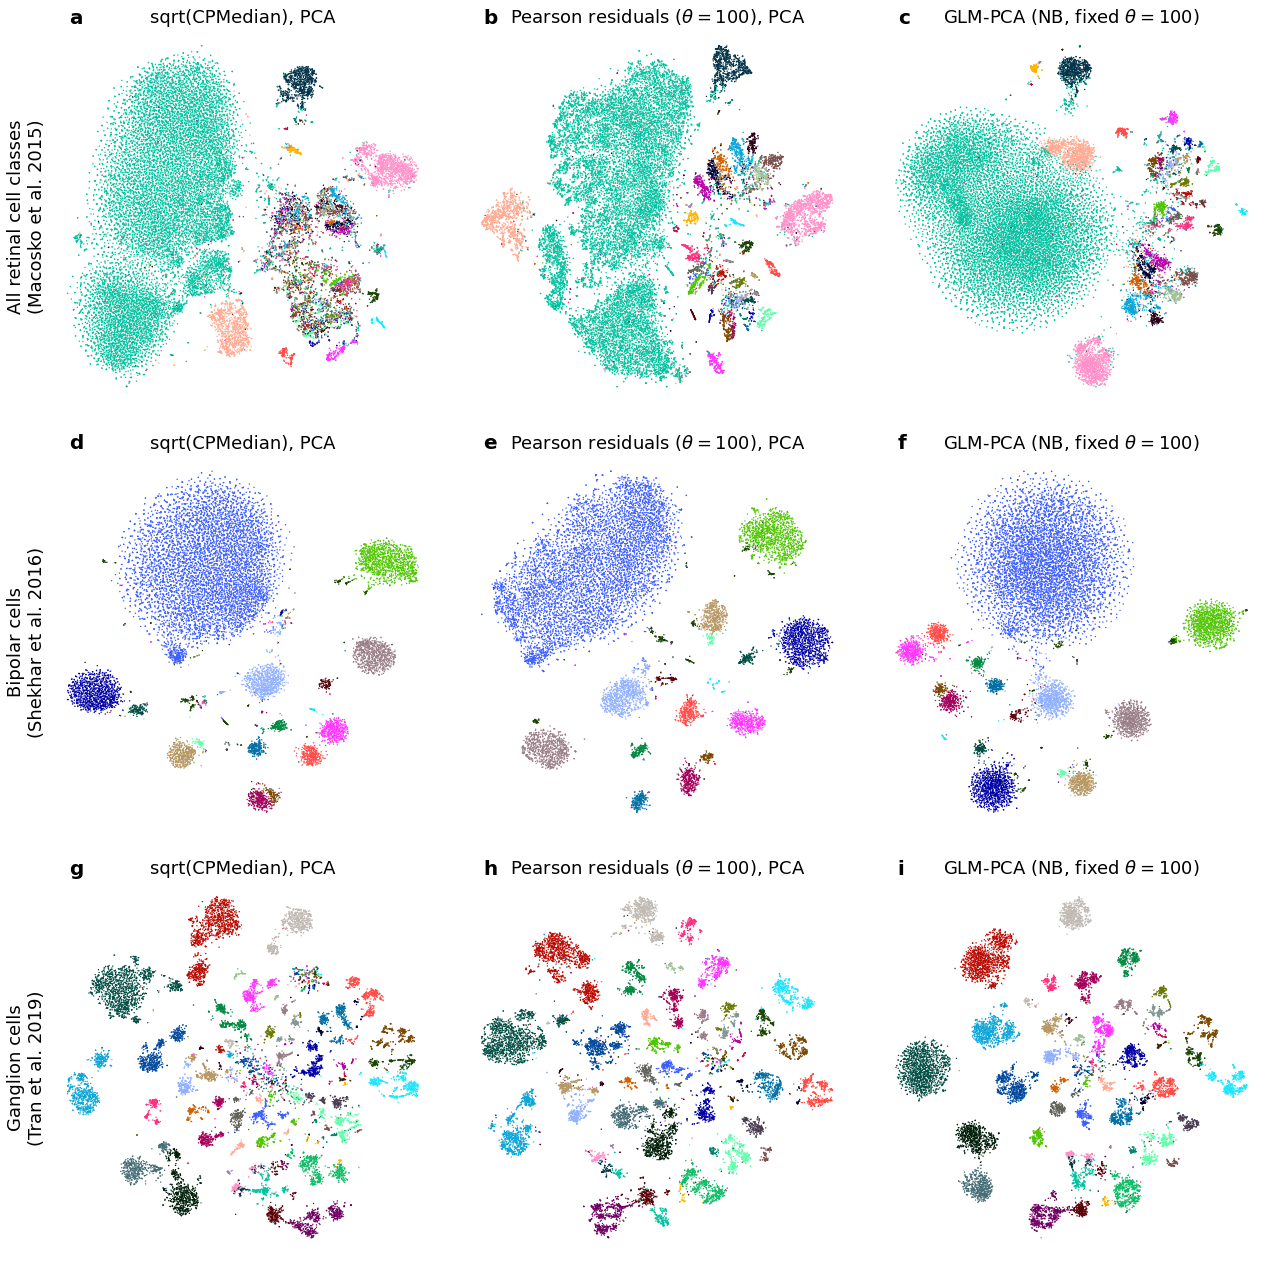

In [14]:
titles = ['sqrt(CPMedian), PCA', r'Pearson residuals ($\theta=100$), PCA',  r'GLM-PCA (NB, fixed $\theta=100$)']
tsne_keys = ['sqrt_lazy_tsne',              'residuals_theta100_tsne','glmpca-py_nb_thetaFixed100_tsne']
letters = ['a','b','c',
           'd','e','f',
           'g','h','i']

with sns.plotting_context('talk'):


    fig,axes = plt.subplots(3,3,figsize=(18,18))
    i=0
    for dataset_id,dataset in enumerate(datasets):

        for method_id,(title,tsne_key) in enumerate(zip(titles,tsne_keys)):

            letter = letters[i]
            i+=1
            
            ax = axes[dataset_id,method_id]
            ax.set_title(title)
            ax.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)

            points = ax.scatter(dataset[tsne_key]['coords'][:,0], dataset[tsne_key]['coords'][:,1], s=2, edgecolor='none',c=dataset['clusters'],cmap=dataset['cmap'], rasterized=True)

            ax.set_xticks([])
            ax.set_yticks([])
            if method_id==0:
                ax.set_ylabel(label_mapping_paper[dataset['labelshort']])
    plt.tight_layout()
    sns.despine(bottom=True,left=True)
    plt.savefig('Fig3.pdf', dpi=300, format=None)

#### Addtional depth-colored tSNEs (correspond to Figure 3)

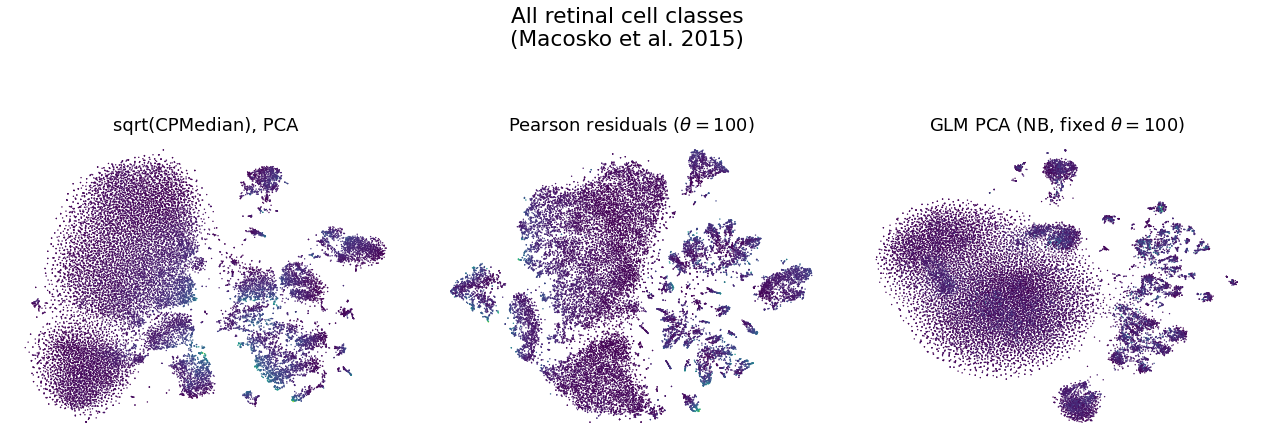

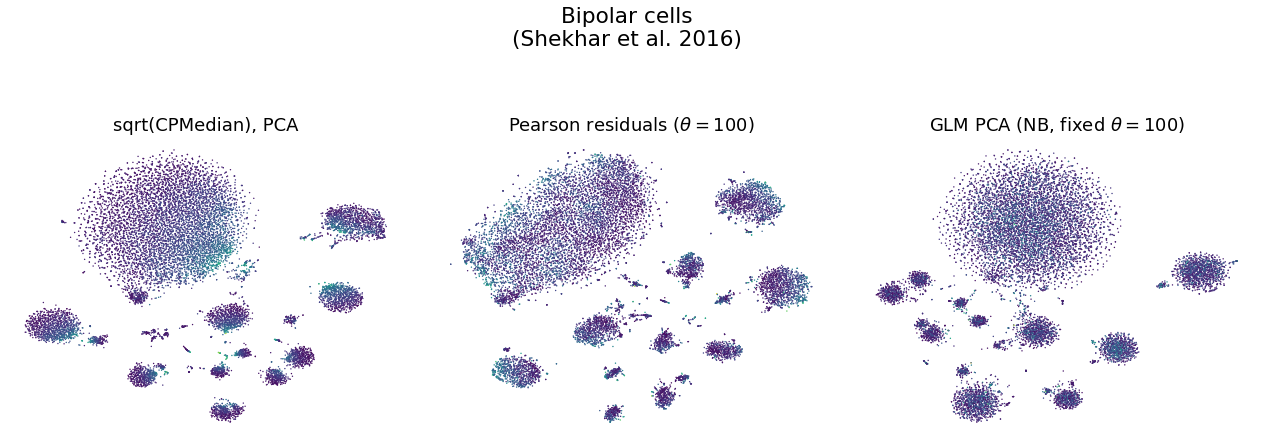

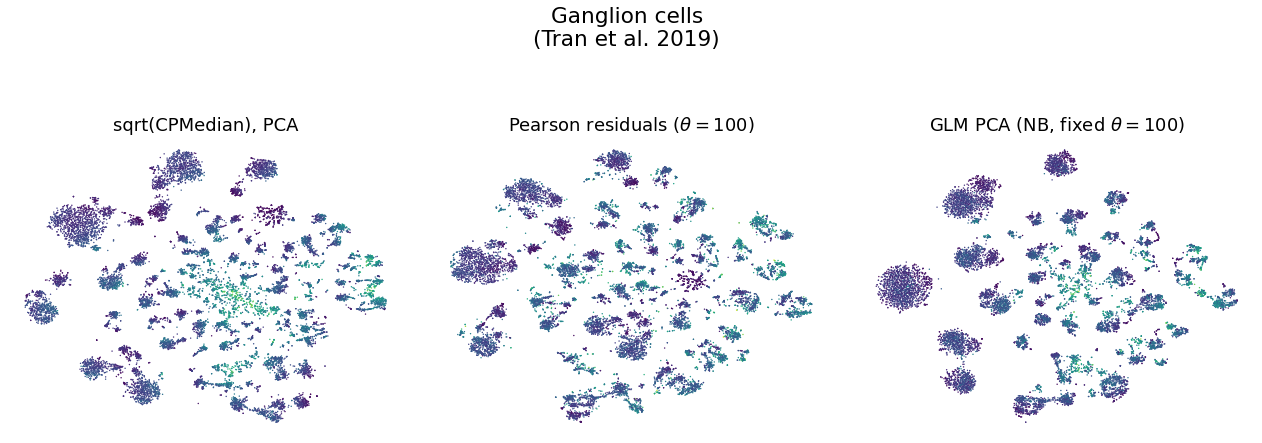

In [15]:
for dataset in datasets:

    with sns.plotting_context('talk'):
        f =plt.figure(figsize=(18,6))

        plt.subplot(131)
        plt.xticks([])
        plt.yticks([])
        plt.title('sqrt(CPMedian), PCA')
        points = plt.scatter(dataset['sqrt_lazy_tsne']['coords'][:,0], dataset['sqrt_lazy_tsne']['coords'][:,1], s=2, edgecolor='none',c=np.sqrt(dataset['depths']))

        plt.subplot(132)
        plt.xticks([])
        plt.yticks([])
        plt.title(r'Pearson residuals ($\theta=100$)')
        points = plt.scatter(dataset['residuals_theta100_tsne']['coords'][:,0], dataset['residuals_theta100_tsne']['coords'][:,1], s=2, edgecolor='none',c=np.sqrt(dataset['depths']))    

        plt.subplot(133)
        plt.xticks([])
        plt.yticks([])
        plt.title(r'GLM PCA (NB, fixed $\theta=100$)')
        points = plt.scatter(dataset['glmpca-py_nb_thetaFixed100_tsne']['coords'][:,0], dataset['glmpca-py_nb_thetaFixed100_tsne']['coords'][:,1], s=2, edgecolor='none',c=np.sqrt(dataset['depths']))    


        plt.suptitle(label_mapping_paper[dataset['labelshort']],y=1.06)

        plt.tight_layout()
        sns.despine(bottom=True,left=True)


#### Additional cell class-colored tSNEs (higher-level labels only available for Macosko data, corresponds to Figure S5)

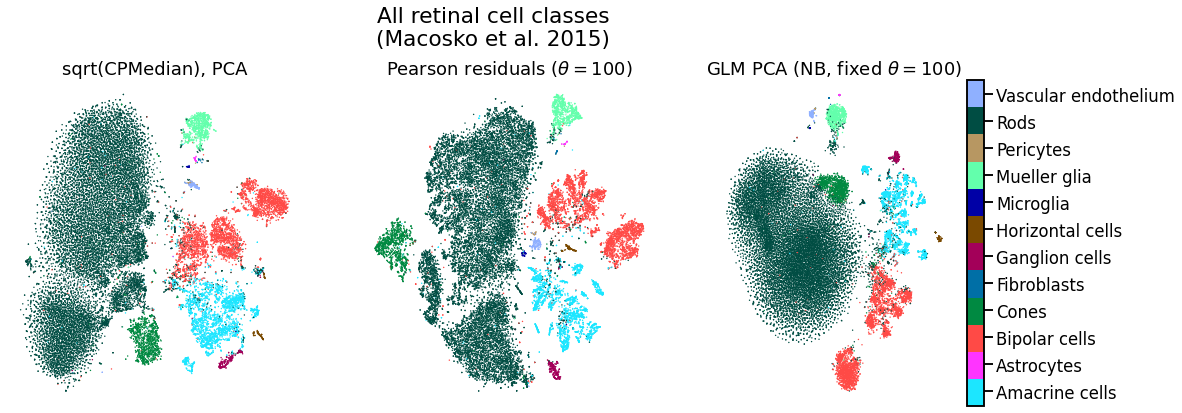

In [16]:
dataset = datasets[0]
classes_str = dataset['class_names'][dataset['clusters']]
class_names,classes = np.unique(classes_str,return_inverse=True)
cmap_macosko_classes = ListedColormap(cmap_colors[:len(class_names)])
with sns.plotting_context('talk'):
    f =plt.figure(figsize=(18,6))

    plt.subplot(131)
    plt.xticks([])
    plt.yticks([])
    plt.title('sqrt(CPMedian), PCA')
    points = plt.scatter(dataset['sqrt_lazy_tsne']['coords'][:,0], dataset['sqrt_lazy_tsne']['coords'][:,1], s=2, edgecolor='none',c=classes,cmap=cmap_macosko_classes)


    plt.subplot(132)  
    plt.xticks([])
    plt.yticks([])  
    plt.title(r'Pearson residuals ($\theta=100$)')
    points = plt.scatter(dataset['residuals_theta100_tsne']['coords'][:,0], dataset['residuals_theta100_tsne']['coords'][:,1], s=2, edgecolor='none',c=classes,cmap=cmap_macosko_classes)    

    plt.subplot(133) 
    plt.xticks([])
    plt.yticks([])   
    plt.title(r'GLM PCA (NB, fixed $\theta=100$)')
    points = plt.scatter(dataset['glmpca-py_nb_thetaFixed100_tsne']['coords'][:,0], dataset['glmpca-py_nb_thetaFixed100_tsne']['coords'][:,1], s=2, edgecolor='none',c=classes,cmap=cmap_macosko_classes)    
    cbar = plt.colorbar(ticks=np.linspace(0.5,10.5,len(class_names)))
    cbar.ax.set_yticklabels(class_names)
    
    plt.suptitle(label_mapping_paper[dataset['labelshort']],y=1.05)

    sns.despine(bottom=True,left=True)


In [17]:
%load_ext watermark

In [18]:
watermark

Last updated: 2021-07-31T19:41:11.047275+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [19]:
watermark --iversions

numpy     : 1.20.1
seaborn   : 0.11.1
matplotlib: 3.3.3

